In [1]:
using JLD, OffsetArrays, LinearAlgebra, ConfParser, ProgressMeter, Colors, Statistics,
    EllipsisNotation, Images, FFTW, Retry, Plots
import OffsetArrays: no_offset_view

In [44]:
function generateConfig(params)
    k, uf, fs_radius, λ₁, λ₂, λ₃, randomize_4D, restart = params
    open("measurements/trial_4/$k.conf", "w") do f
        write(f, """
N                     800
undersampling_rate    $uf
fully_sampled_radius  $fs_radius
lambda_1              $λ₁
lambda_2              $λ₂
lambda_3              $λ₃
randomize_4D          $randomize_4D
restart               $restart
verbose               true
        """)
    end
end

generateConfig (generic function with 1 method)

In [45]:
uf_r_combinations = Array{Tuple{Float64,Float64}}(undef, 0)
for uf in 1//10:1//10:9//10
    for r in [uf//2, uf*2//3, uf*3//4]
        push!(uf_r_combinations, (uf, r))
    end
end

In [46]:
range₁ = [1e-7, 1e-6, 1e-5]
range₂ = [0, 1e-6, 3e-5, 1e-3]
grid = [(uf, r, λ₁₊₂, λ₁₊₂, λ₃, true, true)
            for (uf,r) in uf_r_combinations, λ₁₊₂ in range₁, λ₃ in range₂]
grid = [(i,p...) for (i,p) in enumerate(vec(grid))]
@show length(grid)

length(grid) = 324


324

In [47]:
generateConfig.(grid);

## Evaluate results

In [2]:
@load "true_data.jld"

2-element Array{Symbol,1}:
 :image4D
 :kSpace

In [3]:
image3D = mean(abs.(image4D), dims = 4)
image3D_norm = norm(image3D)
mse_temp = similar(image3D)
mse(img) = norm(mean!(mse_temp, abs.(img)) .-= image3D) / image3D_norm

mse (generic function with 1 method)

In [4]:
function imshow(img::Array{T, 2}; shift = false) where T<:Number
    plot(Gray.(abs.(img)'), seriestype=:image)
end

imshow (generic function with 1 method)

In [48]:
p = Progress(length(filter(x -> endswith(x, ".jld"), readdir("measurements/trial_4/"))), 1)
NMSE, cost = [[Dict() for _ in 1:9] for _ in 1:2]
foreach(readdir("measurements/trial_4/")) do f
    if endswith(f, ".jld")
        conf_filename = "measurements/trial_4/" * split(f, ".")[1] * ".conf"
        conf = ConfParse(conf_filename)
        parse_conf!(conf)
        undersampling_rate = parse(Float64, retrieve(conf, "undersampling_rate"))
        uf = round(Int, undersampling_rate * 10)
        r = parse(Float64, retrieve(conf, "fully_sampled_radius"))
        λ₁ = parse(Float64, retrieve(conf, "lambda_1"))
        λ₂ = parse(Float64, retrieve(conf, "lambda_2"))
        λ₃ = parse(Float64, retrieve(conf, "lambda_3"))
        try
            d = nothing
            @repeat 4 try
                d = jldopen("measurements/trial_4/"*f, "r") do file
                    (NMSE = read(file, "NMSE") , cost = read(file, "cost"))
                end
            catch e
                @delay_retry if true end
            end
            #random = parse(Bool, retrieve(conf, "randomize_4D")) ? ", 4D rand" : ""
            label = "$(split(f, ".")[1]) | r: $(round(r, digits=2)), λ₁₊₂: $λ₁, λ₃: $λ₃"
            NMSE[uf][label] = d[:NMSE]
            cost[uf][label] = d[:cost]
        catch e
        end
        next!(p)
    end
end
finish!(p)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


In [42]:
best_label = ["" for _ in 1:9]
gr()
function compare(idx)
    minimal_values = Array{Tuple{String, Float64}}(undef, 0)
    for (label, series) in NMSE[idx]
        series[series .< series[0]/10] .= NaN
        findfirst(isnan, series) !== nothing && (series[findfirst(isnan, series):end] .= NaN)
        any(x -> x > 1.5, series) && continue
        last_value = findfirst(isnan, series) !== nothing ? findfirst(isnan, series)-1 : length(series)-1
        push!(minimal_values, (label, series[last_value]))
    end
    top_list = sort(minimal_values, lt = (x,y) -> x[2] < y[2])[1:min(end,15)]
    for (label, _) in top_list
        plot!(NMSE[idx][label], label=label, title = "undersampling rate: 0.$idx",
            subplot = idx, xlabel = "k", legend = :outertopleft,
            ylabel="NMSE", size=(800,4000))
    end
    best_label[idx] = top_list[1][1]
end

compare (generic function with 1 method)

In [49]:
plt = plot(layout = (9,1))
[compare(i) for i in 1:9]
plt

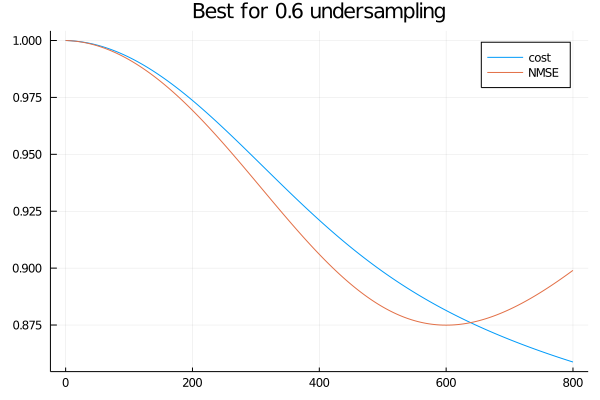

In [31]:
tmp = cost[6][best_label[6]]
#tmp[tmp .> 1000] .= NaN
plot(tmp ./ maximum(filter(!isnan, tmp)),
    title = "Best for 0.6 undersampling", label = "cost")
plot!(NMSE[6][best_label[6]] ./ maximum(filter(!isnan, NMSE[6][best_label[6]])), label = "NMSE")

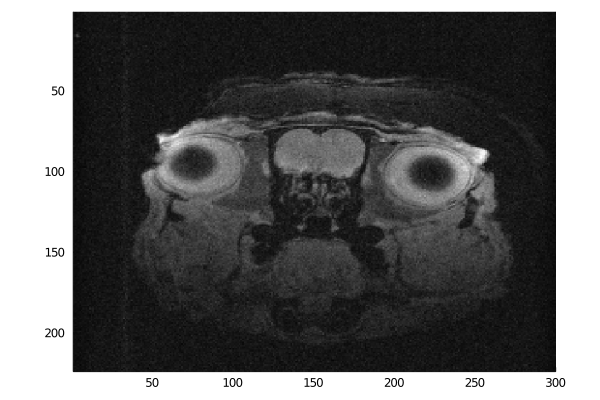

In [16]:
image3D_first_slice = mean(abs.(image4D), dims = 4)[..,24,1]
imshow(fftshift(image3D_first_slice, 1) ./ maximum(abs, image3D_first_slice))

In [17]:
slices = size(image3D, 3)
function eval_result(fname)
    d = load(fname)
    image3D_zf = mean(abs.(d["image4D_zf"]), dims = 4)
    image3D_pogm = mean(abs.(d["image4D_pogm"]), dims = 4)
    ssim_zf = minimum([assess_ssim(image3D[..,i,1], image3D_zf[..,i,1]) for i in 1:slices])
    ssim_pogm = minimum([assess_ssim(image3D[..,i,1], image3D_pogm[..,i,1]) for i in 1:slices])
    NMSE_zf = mse(d["image4D_zf"])
    NMSE_pogm = mse(d["image4D_pogm"])
    plt_pogm = imshow(fftshift(image3D_pogm[..,24,1], 1) ./ maximum(image3D_pogm[..,24,1]))
    ssim_zf, NMSE_zf, ssim_pogm, NMSE_pogm, plt_pogm
end

eval_result (generic function with 1 method)

(ssim_zf, ssim_pogm) = (0.7686497546198275, 0.8252653382405686)
(NMSE_zf, NMSE_pogm) = (0.38271636012784943, 0.32540444119585354)


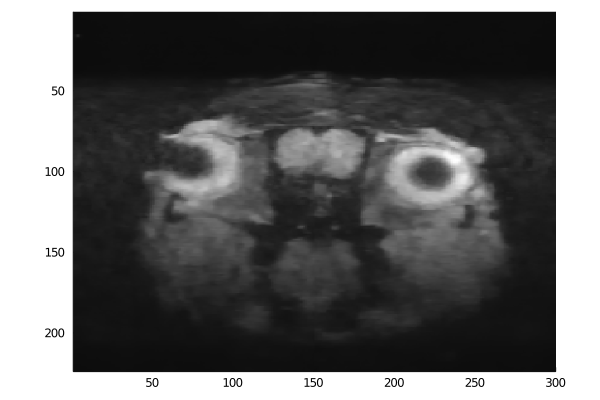

In [18]:
ssim_zf, NMSE_zf, ssim_pogm, NMSE_pogm, plt_pogm =
    eval_result("measurements/trial_4/" * split(best_label[1], " ")[1] * ".jld")
@show ssim_zf, ssim_pogm
@show NMSE_zf, NMSE_pogm
plt_pogm

(ssim_zf, ssim_pogm) = (0.8368122496606156, 0.8902518560458152)
(NMSE_zf, NMSE_pogm) = (0.3104705906436685, 0.2520501659277255)


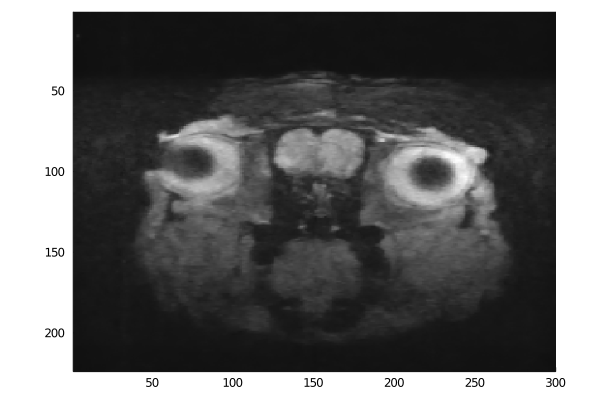

In [19]:
ssim_zf, NMSE_zf, ssim_pogm, NMSE_pogm, plt_pogm =
    eval_result("measurements/trial_4/" * split(best_label[2], " ")[1] * ".jld")
@show ssim_zf, ssim_pogm
@show NMSE_zf, NMSE_pogm
plt_pogm

(ssim_zf, ssim_pogm) = (0.881230637742303, 0.9232368023518195)
(NMSE_zf, NMSE_pogm) = (0.25626731198110286, 0.2041085019794835)


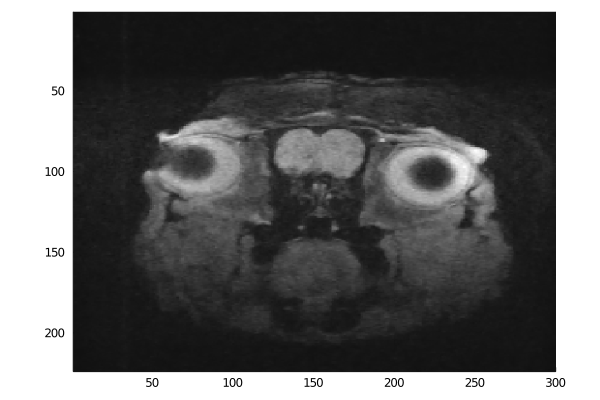

In [20]:
ssim_zf, NMSE_zf, ssim_pogm, NMSE_pogm, plt_pogm =
    eval_result("measurements/trial_4/" * split(best_label[3], " ")[1] * ".jld")
@show ssim_zf, ssim_pogm
@show NMSE_zf, NMSE_pogm
plt_pogm

(ssim_zf, ssim_pogm) = (0.9124500959419045, 0.9399117462629787)
(NMSE_zf, NMSE_pogm) = (0.21625708660833495, 0.174775597194013)


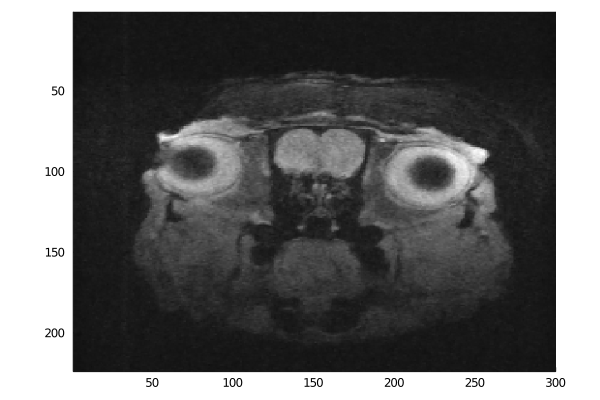

In [21]:
ssim_zf, NMSE_zf, ssim_pogm, NMSE_pogm, plt_pogm =
    eval_result("measurements/trial_4/" * split(best_label[4], " ")[1] * ".jld")
@show ssim_zf, ssim_pogm
@show NMSE_zf, NMSE_pogm
plt_pogm

(ssim_zf, ssim_pogm) = (0.9362591201541803, 0.9512395722620883)
(NMSE_zf, NMSE_pogm) = (0.18213715205099895, 0.15344674238128958)


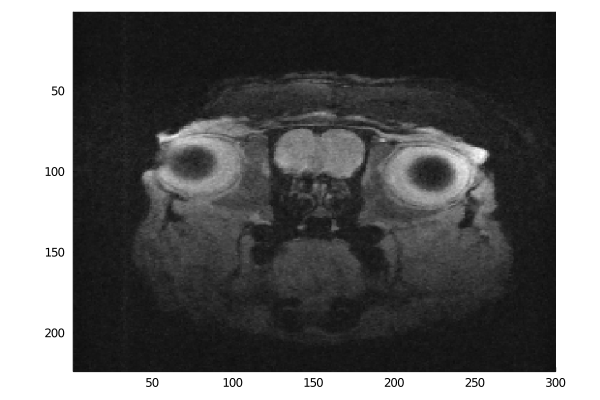

In [22]:
ssim_zf, NMSE_zf, ssim_pogm, NMSE_pogm, plt_pogm =
    eval_result("measurements/trial_4/" * split(best_label[5], " ")[1] * ".jld")
@show ssim_zf, ssim_pogm
@show NMSE_zf, NMSE_pogm
plt_pogm

(ssim_zf, ssim_pogm) = (0.9545014869818231, 0.9597652004528324)
(NMSE_zf, NMSE_pogm) = (0.15116140776324907, 0.135868374716151)


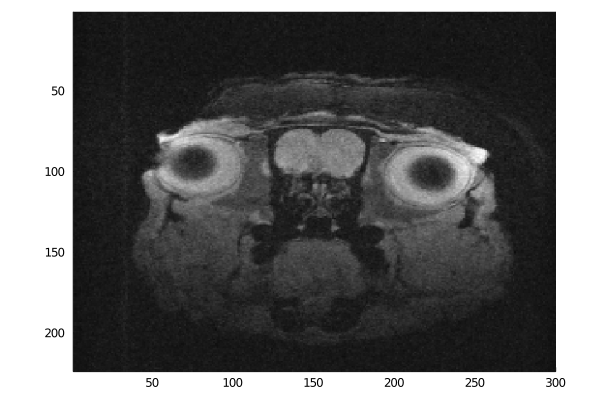

In [23]:
ssim_zf, NMSE_zf, ssim_pogm, NMSE_pogm, plt_pogm =
    eval_result("measurements/trial_4/" * split(best_label[6], " ")[1] * ".jld")
@show ssim_zf, ssim_pogm
@show NMSE_zf, NMSE_pogm
plt_pogm

(ssim_zf, ssim_pogm) = (0.9690345112590593, 0.9700628887958185)
(NMSE_zf, NMSE_pogm) = (0.12304538059797357, 0.11745669438043145)


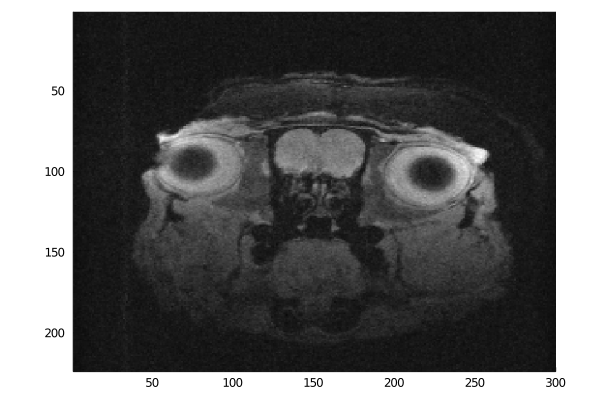

In [24]:
ssim_zf, NMSE_zf, ssim_pogm, NMSE_pogm, plt_pogm =
    eval_result("measurements/trial_4/" * split(best_label[7], " ")[1] * ".jld")
@show ssim_zf, ssim_pogm
@show NMSE_zf, NMSE_pogm
plt_pogm

(ssim_zf, ssim_pogm) = (0.9810809803806149, 0.9796376070191859)
(NMSE_zf, NMSE_pogm) = (0.0948585209462165, 0.0948631674052653)


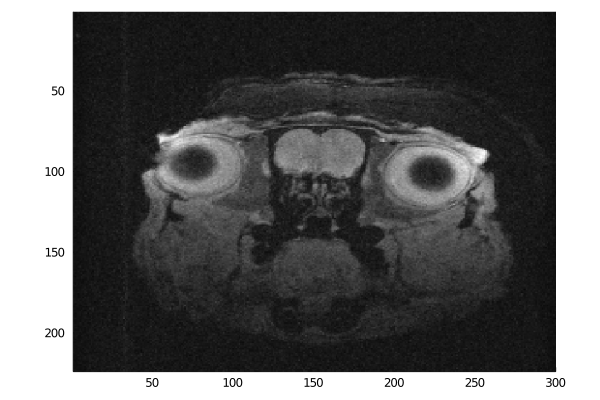

In [25]:
ssim_zf, NMSE_zf, ssim_pogm, NMSE_pogm, plt_pogm =
    eval_result("measurements/trial_4/" * split(best_label[8], " ")[1] * ".jld")
@show ssim_zf, ssim_pogm
@show NMSE_zf, NMSE_pogm
plt_pogm

In [26]:
ssim_zf, NMSE_zf, ssim_pogm, NMSE_pogm, plt_pogm =
    eval_result("measurements/trial_4/" * split(best_label[9], " ")[1] * ".jld")
@show ssim_zf, ssim_pogm
@show NMSE_zf, NMSE_pogm
plt_pogm

(ssim_zf, ssim_pogm) = (0.9911529011920387, 0.9909245150935099)
(NMSE_zf, NMSE_pogm) = (0.062210968826849504, 0.06221288793489868)
